In [ ]:
# Cell 1: Imports & display config
import pandas as pd, numpy as np, joblib, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from datetime import datetime

pd.set_option("display.max_columns", 200)
print("done")


Matplotlib is building the font cache; this may take a moment.


done


In [5]:
# Cell 2: Load raw
# (low_memory=False to avoid mixed dtypes, may take time)
DATA_PATH = Path("/Users/macaryan/Coding/Shodh_AI/lendingclub-policy-optimization/data/accepted_2007_to_2018Q4.csv") 
df = pd.read_csv(DATA_PATH, low_memory=False)
print(df.shape)
df.head(3)


(2260701, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [6]:
# Cell 3: Target mapping
DEFAULTS = {
    "Charged Off","Default","Late (31-120 days)","Late (16-30 days)",
    "Does not meet the credit policy. Status:Charged Off"
}
PAID = {"Fully Paid","Does not meet the credit policy. Status:Fully Paid"}

df = df[df["loan_status"].isin(DEFAULTS | PAID)].copy()
df["y"] = df["loan_status"].isin(DEFAULTS).astype(int)
df["issue_d"] = pd.to_datetime(df["issue_d"], format="%b-%Y", errors="coerce")
df = df.dropna(subset=["issue_d"])
print("Class balance:", df["y"].value_counts(normalize=True).to_dict())


Class balance: {0: 0.7851570148080486, 1: 0.21484298519195147}


In [7]:
# Cell 4: Column selection (pre-decision) & raw cleaning helpers
NUM_COLS = ["loan_amnt","int_rate","emp_length","annual_inc","dti","delinq_2yrs",
            "inq_last_6mths","open_acc","pub_rec","revol_util","total_acc","mort_acc",
            "fico_range_low","fico_range_high"]
CAT_COLS = ["term","home_ownership","verification_status","purpose","addr_state","application_type"]
META_COLS = ["issue_d","loan_amnt","int_rate"]  # useful later for policy/reward

keep = list(set(NUM_COLS + CAT_COLS + META_COLS + ["y"]))  # safe set union
df = df[[c for c in keep if c in df.columns]].copy()

def pct_to_float(s):
    # "13.98%" -> 0.1398 ; handles already-numeric gracefully
    return pd.to_numeric(s.astype(str).str.replace("%","", regex=False), errors="coerce")/100.0

def term_to_months(s):
    # "36 months" -> 36 ; "60 months" -> 60
    return pd.to_numeric(s.astype(str).str.extract(r"(\d+)")[0], errors="coerce")

def emp_to_years(s):
    # e.g., "< 1 year" -> 0, "10+ years" -> 10, "3 years" -> 3
    s = s.astype(str).str.lower().str.strip()
    s = s.replace({"n/a": np.nan})
    s = s.str.replace("< 1 year","0", regex=False)
    s = s.str.replace("10+ years","10", regex=False)
    return pd.to_numeric(s.str.extract(r"(\d+)")[0], errors="coerce")

# Apply conversions if present
if "int_rate" in df.columns:
    df["int_rate"] = pct_to_float(df["int_rate"])
if "revol_util" in df.columns:
    df["revol_util"] = pct_to_float(df["revol_util"])
if "term" in df.columns:
    df["term"] = term_to_months(df["term"])
if "emp_length" in df.columns:
    df["emp_length"] = emp_to_years(df["emp_length"])

# Coerce numerics that might be objects
for c in NUM_COLS:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Quick sanity
df[NUM_COLS + CAT_COLS + ["y"]].head(3)


,loan_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,mort_acc,fico_range_low,fico_range_high,term,home_ownership,verification_status,purpose,addr_state,application_type,y
0,3600.0,0.1399,10.0,55000.0,5.91,0.0,1.0,7.0,0.0,0.297,13.0,1.0,675.0,679.0,36,MORTGAGE,Not Verified,debt_consolidation,PA,Individual,0
1,24700.0,0.1199,10.0,65000.0,16.06,1.0,4.0,22.0,0.0,0.192,38.0,4.0,715.0,719.0,36,MORTGAGE,Not Verified,small_business,SD,Individual,0
2,20000.0,0.1078,10.0,63000.0,10.78,0.0,0.0,6.0,0.0,0.562,18.0,5.0,695.0,699.0,60,MORTGAGE,Not Verified,home_improvement,IL,Joint App,0


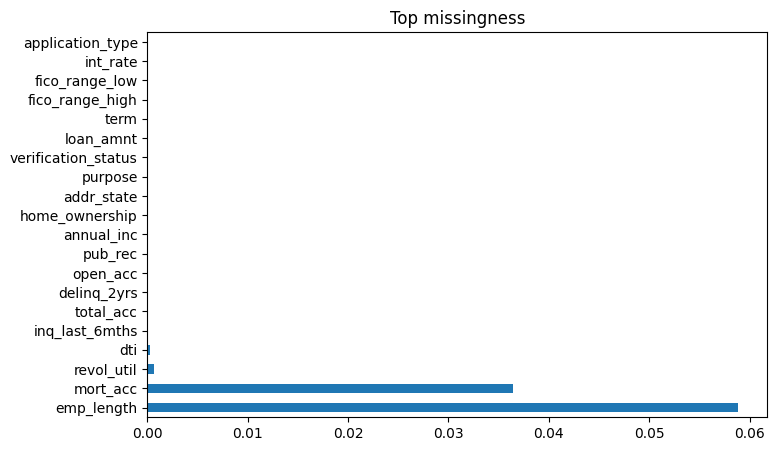

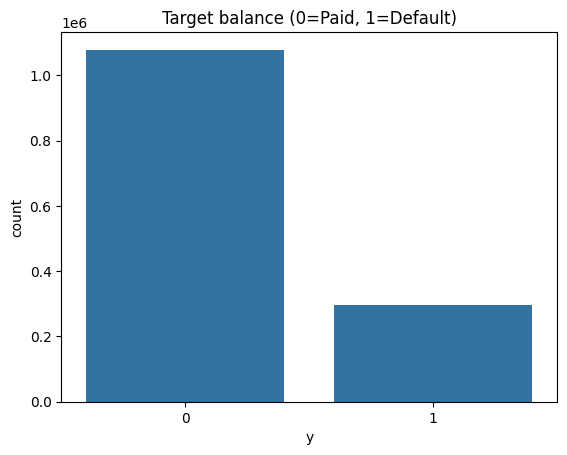

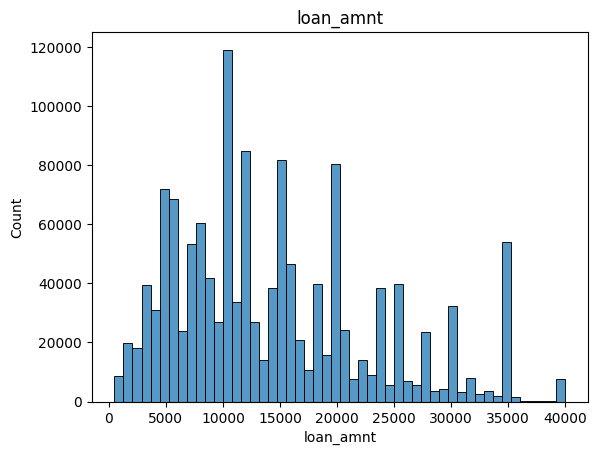

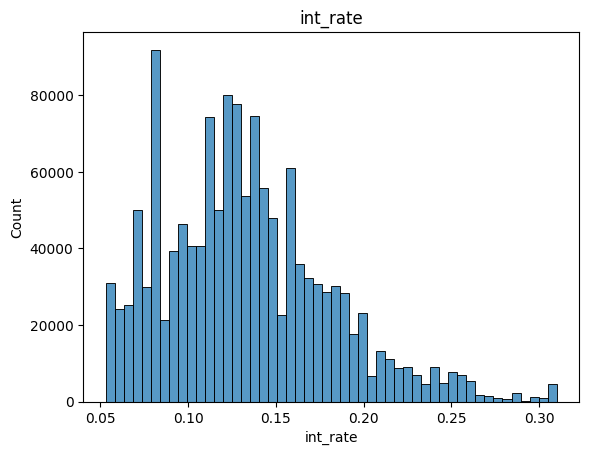

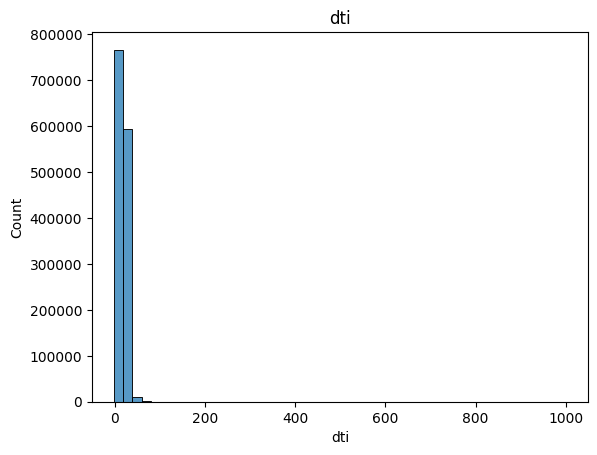

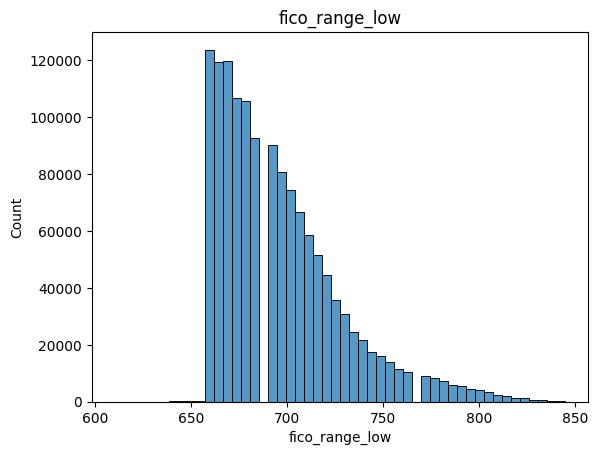

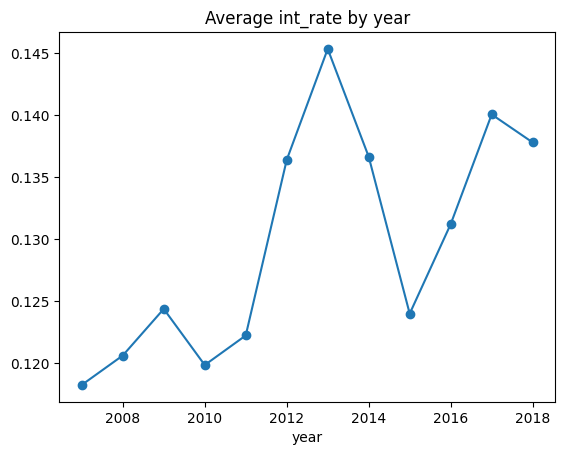

In [8]:
# Cell 5: EDA — missingness, class balance, quick distributions
missing = df[NUM_COLS + CAT_COLS].isna().mean().sort_values(ascending=False).head(30)
plt.figure(figsize=(8,5)); missing.plot.barh(); plt.title("Top missingness"); plt.show()

sns.countplot(x="y", data=df)
plt.title("Target balance (0=Paid, 1=Default)"); plt.show()

for col in ["loan_amnt","int_rate","dti","fico_range_low"]:
    if col in df.columns:
        sns.histplot(df[col].dropna(), bins=50); plt.title(col); plt.show()

# Drift by year (example: int_rate)
df["year"] = df["issue_d"].dt.year
if "int_rate" in df.columns:
    df.groupby("year")["int_rate"].mean().plot(marker="o")
    plt.title("Average int_rate by year"); plt.show()


In [9]:
# Cell 6: Time-based split
train = df[df["issue_d"] < "2017-01-01"].copy()
valid = df[(df["issue_d"] >= "2017-01-01") & (df["issue_d"] < "2018-01-01")].copy()
test  = df[df["issue_d"] >= "2018-01-01"].copy()

def get_Xy(frame):
    X = frame[NUM_COLS + CAT_COLS].copy()
    y = frame["y"].values
    meta = frame[["loan_amnt","int_rate"]].copy() if {"loan_amnt","int_rate"}.issubset(frame.columns) else None
    return X, y, meta

Xtr_raw, ytr, tr_meta = get_Xy(train)
Xva_raw, yva, va_meta = get_Xy(valid)
Xte_raw, yte, te_meta = get_Xy(test)

len(Xtr_raw), len(Xva_raw), len(Xte_raw)


(1129956, 178817, 65142)

In [10]:
# Cell 7: Preprocessor (your pipeline) + fit on TRAIN only, transform others
def clip_by_col_quantiles(X):
    # robust winsorization by column on numeric matrix
    # X is numpy array here (after SimpleImputer)
    q1 = np.nanpercentile(X, 1, axis=0)
    q99 = np.nanpercentile(X, 99, axis=0)
    return np.clip(X, q1, q99)

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("clipper", FunctionTransformer(clip_by_col_quantiles, feature_names_out="one-to-one")),
    ("scaler", StandardScaler())
])

# OneHotEncoder min_frequency needs sklearn>=1.1; if older, remove `min_frequency`
cat_ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=0.01)

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", cat_ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, [c for c in NUM_COLS if c in Xtr_raw.columns]),
        ("cat", cat_pipe, [c for c in CAT_COLS if c in Xtr_raw.columns]),
    ],
    sparse_threshold=0.3
)

Xtr = preprocessor.fit_transform(Xtr_raw)
Xva = preprocessor.transform(Xva_raw)
Xte = preprocessor.transform(Xte_raw)

Xtr.shape, Xva.shape, Xte.shape


((1129956, 63), (178817, 63), (65142, 63))

In [14]:
# put this at the very top of the notebook
import sys
from pathlib import Path

# if you're running the notebook from lendingclub-policy-optimization/notebooks
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

from src.features import make_preprocessor

preprocessor = make_preprocessor()
Xtr = preprocessor.fit_transform(Xtr_raw)
Xva = preprocessor.transform(Xva_raw)
Xte = preprocessor.transform(Xte_raw)
import joblib; joblib.dump(preprocessor, "preprocessor.joblib")


['preprocessor.joblib']

In [12]:
# Cell 9: Quick leakage sanity checks (optional but good practice)
#  - Ensure we did not accidentally include post-outcome fields
potential_leak = [c for c in df.columns if "pymnt" in c or "recover" in c or "last_pymnt" in c or "out_prncp" in c]
potential_leak


[]